## Classifying CIFAR-10 with Data Augmentation

In this exercise, we revisit CIFAR-10 and the networks we previously built.  We will use real-time data augmentation to try to improve our results.

When you are done going through the notebook, experiment with different data augmentation parameters and see if they help (or hurt!) the performance of your classifier.

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
%matplotlib inline

## Testing ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


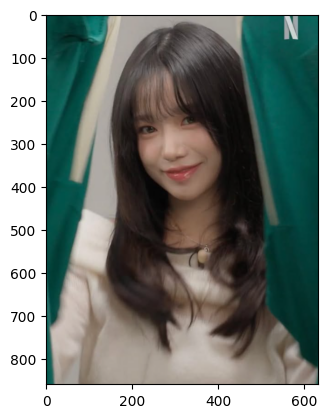

In [4]:
from PIL import Image
import numpy as np

example_image = '/content/drive/MyDrive/Colab Notebooks/Y3T2[DeepLearning]/Study/Dataset/❤.png'

image = Image.open(example_image)
image = np.expand_dims(image, axis=0).astype('float32')/255
plt.imshow(image[0])

In [6]:
datagen = ImageDataGenerator(
    rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

image_generator = datagen.flow(image)

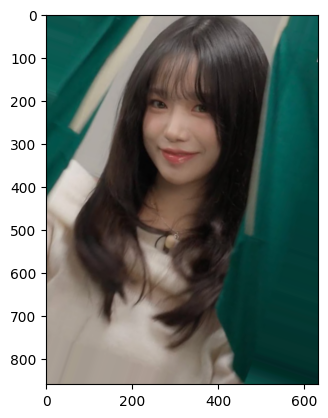

In [8]:
plt.imshow(next(image_generator)[0])

In [9]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [10]:
import numpy as np
import os, random, tensorflow as tf

def set_seed(seed_value=1234):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

set_seed(1234)

## <span style="color:red">Cell ที่เป็นโค้ดหรือคำอธิบายคำตอบ ขอให้สังเกตเห็นได้อย่างชัดเจน</span>

## <span style="color:orange">1. แบ่งข้อมูลออกเป็น train set, val set, และ test set</span>
### * ให้แบ่งข้อมูล val set ออกมาจาก training data โดยให้ใน val set มีข้อมูลของแต่ละคลาสจำนวน 1000 รายการ โดยเป็น 1000 รายการสุดท้ายของแต่ละคลาสที่อยู่ใน training data
### * ให้ปรับโค้ดข้างล่างต่อจากนี้ไปให้ใช้ train set และ val set ในช่วงการเทรน และใช้ test set ในการประเมินประสิทธิภาพของโมเดลที่เทรนได้

In [11]:
'''ตอบคำถามจากโจทย์ ข้อ 1.1 '''
def extract_val_set(x_train, y_train, nums_classes = 10, val_samples_per_class = 1000):
  """
  Args:
        x_train: Training data.
        y_train: Training labels (one-hot encoded).
        num_classes: Number of classes.
        val_samples_per_class: Number of validation samples per class.

    Returns:
        x_train_new: New training data after removing validation samples.
        y_train_new: New training labels after removing validation samples.
        x_val: Validation data.
        y_val: Validation labels.
    """
  x_val, y_val = [], []
  for class_idx in range(num_classes):
      # Get indices of samples belonging to the current class
      class_indices = np.where(np.argmax(y_train, axis=1) == class_idx)[0]
      # Select the last val_samples_per_class samples for validation
      val_indices = class_indices[-val_samples_per_class:]
      # Append validation samples and labels
      x_val.extend(x_train[val_indices])
      y_val.extend(y_train[val_indices])
      # Remove validation samples from training data
      x_train = np.delete(x_train, val_indices, axis=0)
      y_train = np.delete(y_train, val_indices, axis=0)

  return x_train, y_train, np.array(x_val), np.array(y_val)

In [12]:
''' ตอบคำถามจากโจทย์ ข้อ 3 ในการสร้างกราฟเพื่อแสดงประสิทธิภาพ'''
def track_performance(history):
  fig = plt.figure(figsize=(14, 5), dpi=80)
  ax = fig.add_subplot(1, 2, 1)
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax.plot(history.history['loss'])
  ax.plot(history.history['val_loss'])
  ax.set_title('Loss')
  ax.set_ylabel('loss')
  ax.set_xlabel('epoch')
  ax.legend(['train', 'val'], loc='upper right')

  ax = fig.add_subplot(1, 2, 2)
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax.plot(history.history['accuracy'])
  ax.plot(history.history['val_accuracy'])
  ax.set_title('Accuracy')
  ax.set_ylabel('accuracy')
  ax.set_xlabel('epoch')
  ax.legend(['train', 'val'], loc='lower right')

In [13]:
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [14]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [15]:
''' ตอบคำถามจากโจทย์ ข้อ 1.2 '''
x_train, y_train, x_val, y_val = extract_val_set(x_train, y_train, num_classes, 1000)
print("Data after separate to validation set")
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print("We have 10 classes and each class use 1000 samples.")
print(x_val.shape[0], 'x_val samples')
print(x_test.shape[0], 'test samples')

Data after separate to validation set
x_train shape: (40000, 32, 32, 3)
40000 train samples
We have 10 classes and each class use 1000 samples.
10000 x_val samples
10000 test samples


## <span style="color:orange">2. เปรียบเทียบโมเดลที่มีการใช้ Data Augmentation กับโมเดลที่ไม่ได้ใช้</span>
### * ให้ใช้โครงสร้างของ model_1 ในการตอบคำถามในข้อนี้ โดยห้ามเปลี่ยนแปลงโครงสร้างของโมเดล แต่สามารถปรับเปลี่ยนตัว optimizer และค่า learning rate ได้เท่านั้น
### * ให้เปรียบเทียบและแสดงประสิทธิภาพของโมเดลที่มีการใช้ Data Augmentation กับโมเดลที่ไม่ได้ใช้
### * ให้อธิบายเหตุผลที่ทำได้ผลที่ได้จากโมเดลทั้ง 2 ออกมาเป็นเช่นนั้น

In [16]:
# Let's build a CNN using Keras' Sequential capabilities

model_1 = Sequential()

## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2), padding='same',
                 input_shape=x_train.shape[1:]))
model_1.add(Activation('relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2)))
model_1.add(Activation('relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

model_1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 16, 16, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 6, 6, 32)            │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         147,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 181,162 (707.66 KB)

 Trainable params: 181,162 (707.66 KB)

 Non-trainable params: 0 (0.00 B)

We still have 181K parameters, even though this is a "small" model.


In [17]:
batch_size = 32

# initiate RMSprop optimizer
# opt = keras.optimizers.RMSprop(lr=0.0005, decay=1e-6)
opt = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Here we define the `ImageDataGenerator` that we will use to serve images to our model during the training process.  Currently, it is configured to do some shifting and horizontal flipping.

In [18]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

datagen.fit(x_train)  # This computes any statistics that may be needed (e.g. for centering) from the training set.

# Fit the model on the batches generated by datagen.flow().
''' ทำข้อ 1.2 นั่นคือการใช้ข้อมูลจาก val_set มาใช้ในช่วงการ train '''
history_1 = model_1.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
            steps_per_epoch=x_train.shape[0] // batch_size,
            epochs=15,
            validation_data=(x_val, y_val))

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 37ms/step - accuracy: 0.2585 - loss: 1.9925 - val_accuracy: 0.4394 - val_loss: 1.5567
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 36ms/step - accuracy: 0.4199 - loss: 1.5976 - val_accuracy: 0.5001 - val_loss: 1.3929
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.4582 - loss: 1.5003 - val_accuracy: 0.5237 - val_loss: 1.3409
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.4810 - loss: 1.4400 - val_accuracy: 0.5446 - val_loss: 1.2719
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.4929 - loss: 1.4114 - val_accuracy: 0.5512 - val_loss: 1.2528
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 36ms/step - accuracy: 0.5094 - loss: 1.3712 - val_accuracy: 0.5713 - val_loss: 1.2135
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - accuracy: 0.5144 - loss: 1.3613 - val_accuracy: 0.5782 - val_loss: 1.1828
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 36ms/step - accuracy: 0.5184 - loss: 1.34

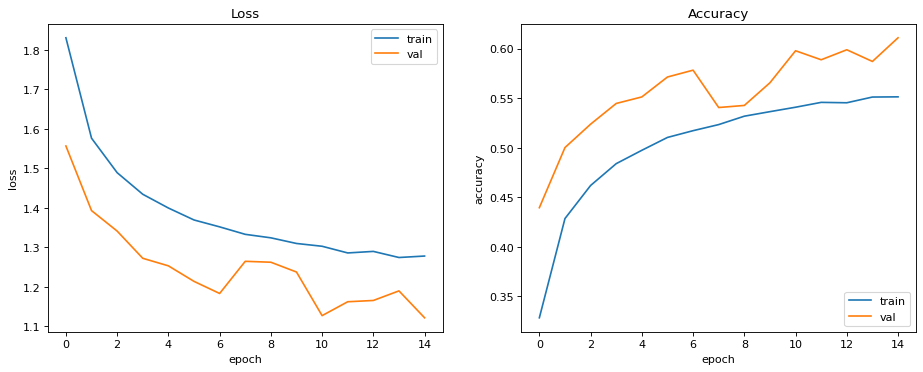

In [19]:
track_performance(history_1)

In [20]:
''' ทำข้อ 1.2 คือการเอา x_test และ y_test มาทำการประเมินประสิทธิภาพของโมเดล '''
print('     Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_train, y_train, verbose=0)))
print('      Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_test, y_test, verbose=0)))
print('Validation Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_val, y_val, verbose = 0)))

     Train Loss: 1.073319, Accuracy: 0.624525
      Test Loss: 1.101042, Accuracy: 0.613400
Validation Loss: 1.121148, Accuracy: 0.610900


## <span style="color:orange">3. ปรับจูนโมเดลให้ดีขึ้น</span>
### * ให้สร้างโมเดลที่มีความซับซ้อนมากขึ้น โดยใช้ข้อกำหนดดังนี้

    * Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification
    * Use strides of 1 for all convolutional layers.
    
### * ให้เปรียบเทียบและแสดงประสิทธิภาพของโมเดลใหม่นี้ที่มีการใช้ Data Augmentation กับโมเดลที่ไม่ได้ใช้ พร้อมอธิบายเหตุผลที่ทำให้ผลที่ได้จากโมเดลทั้ง 2 ออกมาเป็นเช่นนั้น

In [ ]:
''' ทำข้อ 3.1 สร้างโมเดลที่มีความซับซ้อนดังที่โจทย์กำหนด'''

model_2 = Sequential()

model_2.add(Conv2D(32, (5, 5), strides=(1, 1), padding='same', input_shape=x_train.shape[1:], activation='relu'))
model_2.add(Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu'))
model_2.add(Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Flatten())

model_2.add(Dense(512, activation='relu'))
model_2.add(Dense(num_classes, activation='softmax'))

model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,133,546 (4.32 MB)

 Trainable params: 1,133,546 (4.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 32

# initiate RMSprop optimizer
# opt = keras.optimizers.RMSprop(lr=0.0005, decay=1e-6)
opt = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
model_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
datagen = ImageDataGenerator(
    rotation_range = 45,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    zoom_range = 0.2)

datagen.fit(x_train)

history_2 = model_2.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
            steps_per_epoch=x_train.shape[0] // batch_size,
            epochs=20,
            validation_data=(x_val, y_val))

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 400s 319ms/step - accuracy: 0.2572 - loss: 2.0161 - val_accuracy: 0.4681 - val_loss: 1.4812
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 446s 322ms/step - accuracy: 0.4053 - loss: 1.6477 - val_accuracy: 0.5147 - val_loss: 1.3335
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 461s 338ms/step - accuracy: 0.4600 - loss: 1.5074 - val_accuracy: 0.5347 - val_loss: 1.3095
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 421s 321ms/step - accuracy: 0.4960 - loss: 1.4092 - val_accuracy: 0.5799 - val_loss: 1.2005
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 435s 316ms/step - accuracy: 0.5221 - loss: 1.3272 - val_accuracy: 0.5742 - val_loss: 1.2079
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 409s 328ms/step - accuracy: 0.5415 - loss: 1.2834 - val_accuracy: 0.6238 - val_loss: 1.0713
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 393s 315ms/step - accuracy: 0.5635 - loss: 1.2296 - val_accuracy: 0.6406 - val_loss: 1.0133
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 409s 327ms/step - ac

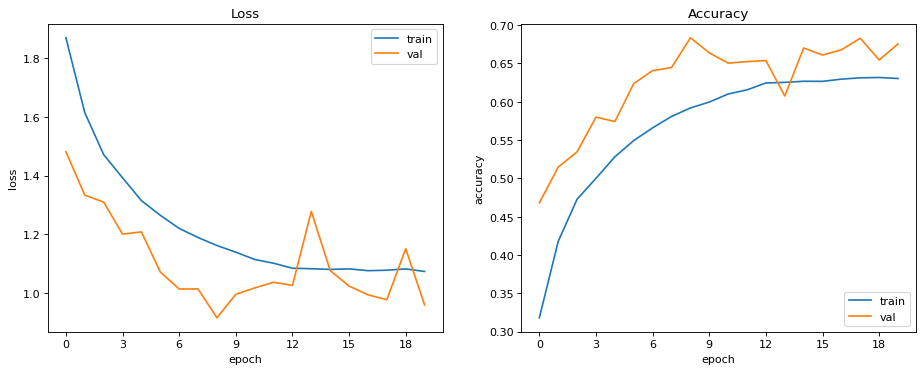

In [ ]:
track_performance(history_2)

In [ ]:
print("Model_1(No Data Augmentation)")
print('     Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_train, y_train, verbose=0)))
print('      Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_test, y_test, verbose=0)))
print('Validation Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_val, y_val, verbose = 0)))
print()
print("Model_2(With Data Augmentation)")
print('     Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_2.evaluate(x_train, y_train, verbose=0)))
print('      Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_2.evaluate(x_test, y_test, verbose=0)))
print('Validation Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_2.evaluate(x_val, y_val, verbose = 0)))

Model_1(No Data Augmentation)
     Train Loss: 1.073319, Accuracy: 0.624525
      Test Loss: 1.101042, Accuracy: 0.613400
Validation Loss: 1.121148, Accuracy: 0.610900

Model_2(With Data Augmentation)
     Train Loss: 0.909092, Accuracy: 0.698175
      Test Loss: 0.962733, Accuracy: 0.682300
Validation Loss: 0.959066, Accuracy: 0.675500


**ข้อ 3.1 อธิบายเหตุผลที่ทำให้ผลที่ได้จากโมเดลทั้ง 2 ออกมาเป็นเช่นนั้น**<br>
ตอบ จากการทดลองที่ผมได้นั่งสังเกตมาเป็นเวลานาน ผมตั้งสมมติฐานจากการสังเกตุเห็นด้วยตัวของผมเองว่า โมเดลที่ 1 ที่ไม่มีการใช้ Data Augmentation มีความเร็วในการคำนวณที่ไวกว่า ซึ่งผมให้เหตุผลว่าเหตุผลที่ทำงานได้ไวกว่า ก็อาจจะมีส่วนจากการที่ CNN มี layer ที่ซับซ้อนน้อยกว่าโมเดลตัวที่ 2 นอกจากนี้ค่า Accuracy ก็มีความแม่นยำที่น้อยกว่าโมเดลที่ 2 ซึ่งเหตุผลที่โมเดลตัวที่ 2 มีความแม่นยำที่สูงกว่าโมเดลตัวที่ 1 นั้น เนื่องจากโมเดลตัวที่ 2 มีการเรียนรู้ผ่านภาพที่มีการทำ Augmentation ซึ่งการทำ Rotation, shift และ operation อื่นๆ ต่างเป็นกระบวนการทำงานที่ต้องใช้เวลาในการประมวลผล ทำให้โมเดลที่ 2 ใช้เวลาในการประมวลผลมากกว่าโมเดลที่ 1 อย่างมาก แต่ค่าความแม่นยำที่ได้ก็ดีกว่า เพราะเหมือนได้เรียนรู้ภาพที่ไม่ได้เป็นลักษณะที่ปกติทั่วไป